# Download Tiny ImageNet dataset from here. Finetune Densenet 121 [20 Marks for
Densenet code and data I/O] with the following.

a) Focal Loss as the final classification loss function.

b) Cross-Entropy as the final classification loss function.

Choose any evaluation metrics (at least 3) and compare the models in a and b,
comment on which one is better and why?

## Data Prepration

In [ ]:
# Downloading and unzipping Data
!curl http://cs231n.stanford.edu/tiny-imagenet-200.zip --output data
!unzip data

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
# Importing Libraries

import os
import copy
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
from shutil import copyfile
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from __future__ import division
from __future__ import print_function
from torch.autograd import Variable
from torchvision import datasets, models, transforms

%matplotlib inline


In [ ]:
# Converting data to proper format using val_annotation file present in dataset folder.
# New folder namely val_new is created which will store image which can be mapped to labels.
def ensure_dataset_loaded():
    val_fixed_folder = "tiny-imagenet-200/val_new"
    os.mkdir(val_fixed_folder)
     
    with open("./tiny-imagenet-200/val/val_annotations.txt") as f:
        for line in f.readlines():
            fields = line.split()

            file_name = fields[0]
            clazz = fields[1]

            class_folder = "./tiny-imagenet-200/val_new/" + clazz
            if not os.path.exists(class_folder):
                os.mkdir(class_folder)

            original_image_path = "./tiny-imagenet-200/val/images/" + file_name
            copied_image_path = class_folder + "/" + file_name

            copyfile(original_image_path, copied_image_path)
ensure_dataset_loaded()

In [ ]:
# Initializing Hyper-PArameter
num_classes = 200
input_size = 224
batch_size = 1000
feature_extract  = True

In [ ]:
#Initializing GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
#Loading Data , Data Augmentation(only for Training) and Normalizing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_new': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join('./tiny-imagenet-200/', x), data_transforms[x]) for x in ['train', 'val_new']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val_new']}


Initializing Datasets and Dataloaders...


In [ ]:
# Defining Function for training

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=False):
    since = time.time()
    
    train_loss = []
    val_loss = []

    train_acc = []
    val_acc = []

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Setting model to training mode or evaluate mode
        for phase in ['train', 'val_new']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if (phase == 'train'):
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
              if (epoch_acc > best_acc):
                best_acc = epoch_acc

            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc) 

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc*100))
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return [train_loss,val_loss,train_acc,val_acc,best_acc]

In [ ]:
# Creating Model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


net = models.densenet121(pretrained=True)
set_parameter_requires_grad(net,True)
num_ftrs = net.classifier.in_features
net.classifier = nn.Linear(num_ftrs, num_classes)
net.to(device)

params_to_update = net.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)


Params to learn:
	 classifier.weight
	 classifier.bias


## Using Cross Entrophy Loss

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
num_epochs = 5

# Train and evaluate
metric_CE_Loss = train_model(net, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 4.3554 Acc: 16.7460
val_new Loss: 3.2736 Acc: 37.7200

Epoch 1/4
----------
train Loss: 3.4040 Acc: 29.8710
val_new Loss: 2.6444 Acc: 44.8000

Epoch 2/4
----------
train Loss: 3.1263 Acc: 33.2320
val_new Loss: 2.4032 Acc: 47.9500

Epoch 3/4
----------
train Loss: 2.9913 Acc: 35.0450
val_new Loss: 2.2626 Acc: 49.9200

Epoch 4/4
----------
train Loss: 2.9139 Acc: 36.0080
val_new Loss: 2.1791 Acc: 51.1700

Training complete in 37m 51s
Best val Acc: 0.360080


In [ ]:
metric_CE_Loss

[[4.355352578163147,
  3.4040049171447753,
  3.1262807202339173,
  2.991307942867279,
  2.9138598108291625],
 [3.2735567331314086,
  2.6444021701812743,
  2.4032477855682375,
  2.2626319885253907,
  2.1791099071502686],
 [tensor(0.1675, device='cuda:0', dtype=torch.float64),
  tensor(0.2987, device='cuda:0', dtype=torch.float64),
  tensor(0.3323, device='cuda:0', dtype=torch.float64),
  tensor(0.3505, device='cuda:0', dtype=torch.float64),
  tensor(0.3601, device='cuda:0', dtype=torch.float64)],
 [tensor(0.3772, device='cuda:0', dtype=torch.float64),
  tensor(0.4480, device='cuda:0', dtype=torch.float64),
  tensor(0.4795, device='cuda:0', dtype=torch.float64),
  tensor(0.4992, device='cuda:0', dtype=torch.float64),
  tensor(0.5117, device='cuda:0', dtype=torch.float64)],
 tensor(0.3601, device='cuda:0', dtype=torch.float64)]

## Using Focal Loss



In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
# Setup the loss fxn
criterion = FocalLoss()
num_epochs = 5

# Train and evaluate
metric_Focal_Loss = train_model(net, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 4.3525 Acc: 16.6470
val_new Loss: 3.2747 Acc: 37.5500

Epoch 1/4
----------
train Loss: 3.4167 Acc: 29.8580
val_new Loss: 2.6485 Acc: 45.5700

Epoch 2/4
----------
train Loss: 3.1181 Acc: 33.5130
val_new Loss: 2.3943 Acc: 48.3700

Epoch 3/4
----------
train Loss: 2.9894 Acc: 35.0450
val_new Loss: 2.2571 Acc: 50.0400

Epoch 4/4
----------
train Loss: 2.9095 Acc: 36.0580
val_new Loss: 2.1812 Acc: 50.7000

Training complete in 36m 39s
Best val Acc: 0.360580


In [ ]:
metric_Focal_Loss

[[4.352459168434143,
  3.4167269372940066,
  3.1180749011039732,
  2.989384963512421,
  2.9095229625701906],
 [3.2746692895889282,
  2.64845666885376,
  2.394318771362305,
  2.2571351528167725,
  2.1812002420425416],
 [tensor(0.1665, device='cuda:0', dtype=torch.float64),
  tensor(0.2986, device='cuda:0', dtype=torch.float64),
  tensor(0.3351, device='cuda:0', dtype=torch.float64),
  tensor(0.3505, device='cuda:0', dtype=torch.float64),
  tensor(0.3606, device='cuda:0', dtype=torch.float64)],
 [tensor(0.3755, device='cuda:0', dtype=torch.float64),
  tensor(0.4557, device='cuda:0', dtype=torch.float64),
  tensor(0.4837, device='cuda:0', dtype=torch.float64),
  tensor(0.5004, device='cuda:0', dtype=torch.float64),
  tensor(0.5070, device='cuda:0', dtype=torch.float64)],
 tensor(0.3606, device='cuda:0', dtype=torch.float64)]

## Comparison

In [ ]:
F_train_loss =  metric_Focal_Loss[0]
F_val_loss = metric_Focal_Loss[1]
F_train_acc =  metric_Focal_Loss[2]
F_val_acc = metric_Focal_Loss[3]

C_train_loss =  metric_CE_Loss[0]
C_val_loss = metric_CE_Loss[1]
C_train_acc =  metric_CE_Loss[2]
C_val_acc = metric_CE_Loss[3]

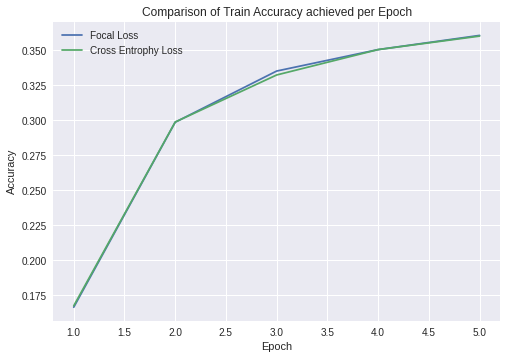

In [ ]:
#Result Comparision in Train Accuracy Achieved using different Loss Function

plt.style.use("seaborn")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Train Accuracy achieved per Epoch")

x = [i for i in range(1,6)]


plt.plot(x,F_train_acc,label="Focal Loss")
plt.plot(x,C_train_acc,label="Cross Entrophy Loss")

plt.legend()
plt.savefig('./Train_ACC.png')
plt.show()

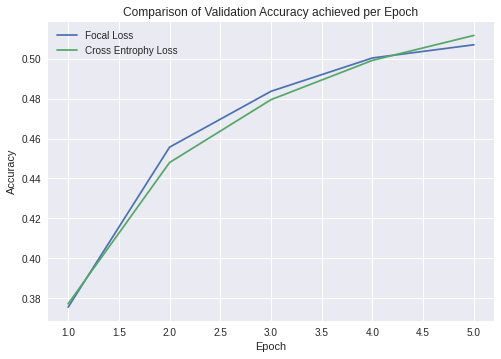

In [ ]:
#Result Comparision in Validation Accuracy Achieved using different Loss Function

plt.style.use("seaborn")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Validation Accuracy achieved per Epoch")

x = [i for i in range(1,6)]


plt.plot(x,F_val_acc,label="Focal Loss")
plt.plot(x,C_val_acc,label="Cross Entrophy Loss")

plt.legend()
plt.savefig('./Val_ACC.png')
plt.show()

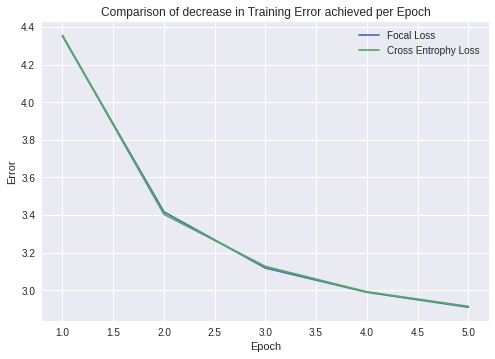

In [ ]:
#Result Comparision in decrease in error using different Loss Function

plt.style.use("seaborn")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Comparison of decrease in Training Error achieved per Epoch")

x = [i for i in range(1,6)]


plt.plot(x,F_train_loss,label="Focal Loss")
plt.plot(x,C_train_loss,label="Cross Entrophy Loss")

plt.legend()
plt.savefig('./Train_Error.png')
plt.show()

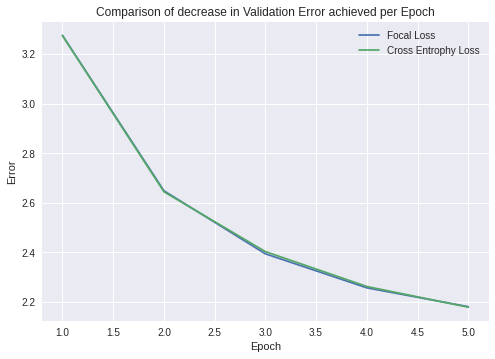

In [ ]:
#Result Comparision in decrease in error using different Loss Function

plt.style.use("seaborn")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Comparison of decrease in Validation Error achieved per Epoch")

x = [i for i in range(1,6)]


plt.plot(x,F_val_loss,label="Focal Loss")
plt.plot(x,C_val_loss,label="Cross Entrophy Loss")

plt.legend()
plt.savefig('./Val_Error.png')
plt.show()